In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Данная библиотека импортируется ИСКЛЮЧИТЕЛЬНО для возможности отображения графиков через
# https://nbviewer.org/ Jupyter Notebook. Для действий над данными, НЕ ИСПОЛЬЗУЕТСЯ!!!
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio 
pio.renderers.default='notebook'

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем дополнительные библиотеки.
from geopy.geocoders import Nominatim
import re
import category_encoders as ce
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tio/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [46]:
# Подгрузим наши данные из соревнования.
df_train = pd.read_csv('../project_3/data/hotels_train.csv.zip', compression='zip') # датасет для обучения
df_test = pd.read_csv('../project_3/data/hotels_test.csv.zip', compression='zip') # датасет для предсказания
sample_submission = pd.read_csv('../project_3/data/submission.csv.zip', compression='zip') # сабмишн

In [47]:
# Проверим данные.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [21]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [65]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [66]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [67]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [23]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# 1  Очистка данных

In [24]:
# Проверим наши данные на наличие пропусков.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

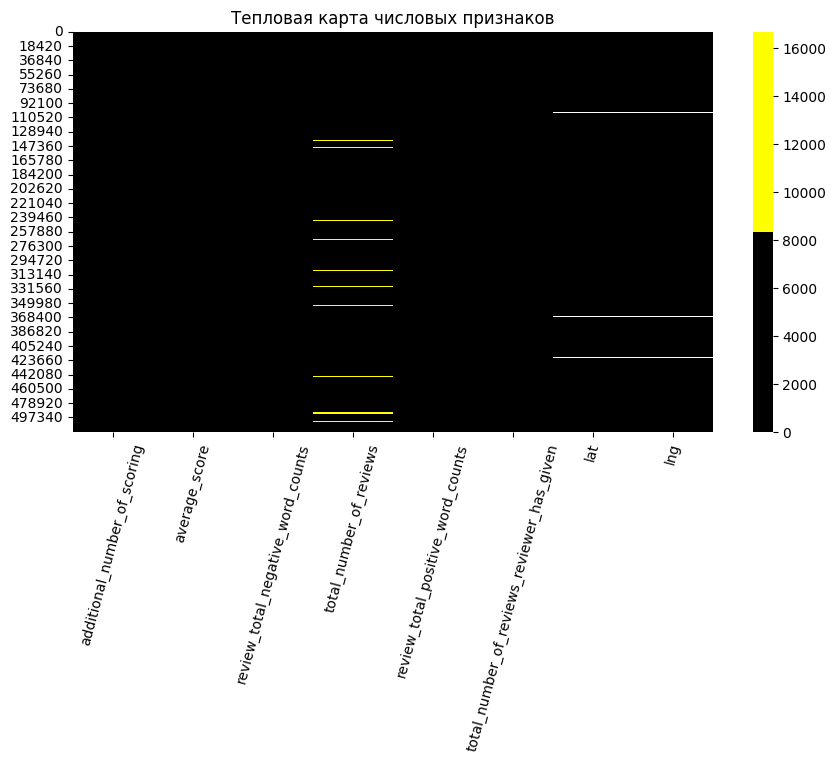

In [25]:
# Создадим список столбцов с числовыми значениями и уберем из него целевой и искусственно созданный признак. 
col = [s for s in data.columns if ((data[s].dtypes == 'int64') or (data[s].dtypes == 'float64'))]
col.remove('sample')
col.remove('reviewer_score')

# Построим тепловую карту для визульного обнаружения пропусков
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1,1,1,1])
sns.heatmap(data[col],
            ax=ax,
            cmap=sns.color_palette(['black','yellow'])
           )
ax.set_title('Тепловая карта числовых признаков')
ax.xaxis.set_tick_params(rotation=75)

##  Восстановление пропущенных значений
Для заполнения пропусков воспользуемся библиотекой geopy модулем geocoders. Координаты восстановим по адресу с помощью класса Nominatim. Пришлось сократить до четырех последних элементов значения из признака адреса отеля, иначе геокодер не находил координаты. К сожалению получить данные сразу для всех адресов не получилось. Видимо из-за ограничеий на количество запросов.  Однако деление данных на части решило проблему.

In [26]:
# Выделим строки с пропусками в отдельный датафрейм.
hotel_no_coord = data[data['lat'].isna()]

# Создадим фунуцию, которая принимает строку и преобразует её в список элементов строки разделенных по пробелу.
# Функция возвращает последние 4 элемента в виде строки. 
def split_s(x, n=4):
    """ Функция извлекает последние n элемента строки, по умолчанию четыре
    Args:
        x (string): исходная строка
        n (int): количество извлекаемых последних элементов исходной строки,
        по умоолчанию 4 элемента.

    Returns:
        (string): строка содержащая n последних элементов исходной строки
    """
    str = x.split(' ')
    return ' '.join(str[-n:])

# Создадим признак 'adress' используя функцию split
hotel_no_coord['adress'] = hotel_no_coord['hotel_address'].apply(lambda x: split_s(x, n=4))

# Разделим данные на части, не превышающие 1000 строк.
hotel_no_coord_part_1 = hotel_no_coord.iloc[:1000, :]
hotel_no_coord_part_2 = hotel_no_coord.iloc[1000:2000, :]
hotel_no_coord_part_3 = hotel_no_coord.iloc[2000:3000, :]
hotel_no_coord_part_4 = hotel_no_coord.iloc[3000:, :]

# Проверим результат. 
print(f"Всего пропусков: {data['lat'].isna().sum()}\n", 
      f"часть 1: {hotel_no_coord_part_1.shape[0]}\n",
      f"часть 2: {hotel_no_coord_part_2.shape[0]}\n",
      f"часть 3: {hotel_no_coord_part_3.shape[0]}\n",
      f"часть 4: {hotel_no_coord_part_4.shape[0]}")

Всего пропусков: 3268
 часть 1: 1000
 часть 2: 1000
 часть 3: 1000
 часть 4: 268


In [27]:
# Используем геокодер Nominatim.
geolocator = Nominatim(user_agent="Tester") # Для работы нужно указать название приложения.

# Применим метод .geocode() к каждому адресу, результат запишем в новый признак.
hotel_no_coord_part_1['location'] = hotel_no_coord_part_1['adress'].apply(lambda x: geolocator.geocode(x))

# Проверяем наличие пропусков в новом признаке. 
hotel_no_coord_part_1[['location']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 35 to 160933
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  929 non-null    object
dtypes: object(1)
memory usage: 15.6+ KB


In [28]:
# Для некоторых адресов не удалось получить сведенья - в признаке 'location' есть пропуски.
# Видимо часть адресов была указана не корректно. Разделим данные на две части по отсутствию/наличию 
# пропусков в признаке 'location'.
part_1_st_1 = hotel_no_coord_part_1[~(hotel_no_coord_part_1['location'].isna())]
part_1_st_2 = hotel_no_coord_part_1[hotel_no_coord_part_1['location'].isna()]

# Перезададим признак 'adress' для данных с пропусками, используя функцию split_s и сократив адрес до 3 элементов.
part_1_st_2['adress'] = part_1_st_2['hotel_address'].apply(lambda x: split_s(x, n=3))

# Попытаемся восстановить координаты.
part_1_st_2['location'] = part_1_st_2['adress'].apply(lambda x: geolocator.geocode(x))

# Объединим данные и проверяем отсутствие пропусков в признаке 'location'.
df_part_1 = pd.concat([part_1_st_1, part_1_st_2 ])
display(df_part_1[['location']].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 35 to 159110
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  1000 non-null   object
dtypes: object(1)
memory usage: 15.6+ KB


None

In [29]:
# Повторим процедуру для второй, третьей и четвертой частей данных. 
hotel_no_coord_part_2['location'] = hotel_no_coord_part_2['adress'].apply(lambda x: geolocator.geocode(x))
part_2_st_1 = hotel_no_coord_part_2[~(hotel_no_coord_part_2['location'].isna())]
part_2_st_2 = hotel_no_coord_part_2[hotel_no_coord_part_2['location'].isna()]
part_2_st_2['adress'] = part_2_st_2['hotel_address'].apply(lambda x: split_s(x, n=3))
part_2_st_2['location'] = part_2_st_2['adress'].apply(lambda x: geolocator.geocode(x))
df_part_2 = pd.concat([part_2_st_1,part_2_st_2 ])

hotel_no_coord_part_3['location'] = hotel_no_coord_part_3['adress'].apply(lambda x: geolocator.geocode(x))
part_3_st_1 = hotel_no_coord_part_3[~(hotel_no_coord_part_3['location'].isna())]
part_3_st_2 = hotel_no_coord_part_3[hotel_no_coord_part_3['location'].isna()]
part_3_st_2['adress'] = part_3_st_2['hotel_address'].apply(lambda x: split_s(x, n=3))
part_3_st_2['location'] = part_3_st_2['adress'].apply(lambda x: geolocator.geocode(x))
df_part_3 = pd.concat([part_3_st_1,part_3_st_2 ])

hotel_no_coord_part_4['location'] = hotel_no_coord_part_4['adress'].apply(lambda x: geolocator.geocode(x))
part_4_st_1 = hotel_no_coord_part_4[~(hotel_no_coord_part_4['location'].isna())]
part_4_st_2 = hotel_no_coord_part_4[hotel_no_coord_part_4['location'].isna()]
part_4_st_2['adress'] = part_4_st_2['hotel_address'].apply(lambda x: split_s(x, n=3))
part_4_st_2['location'] = part_4_st_2['adress'].apply(lambda x: geolocator.geocode(x))
df_part_4 = pd.concat([part_4_st_1,part_4_st_2 ])



In [30]:
# Объединим все три части в один датафрейм.
df_restore = pd.concat([df_part_1, df_part_2, df_part_3, df_part_4])

# Запишем значения координат в соответствующие признаки используя методы геолокатора .latitude() и longitude().
df_restore['lat'] = df_restore['location'].apply(lambda x: x.latitude)
df_restore['lng'] = df_restore['location'].apply(lambda x: x.longitude)

# Удалим вспомогательные столбцы.
df_restore.drop(['adress', 'location'], axis=1, inplace=True)

# Проверим результат.
display(df_restore[['lat', 'lng']].info())

# Объединим данные с исходным датафреймом по всем столбцам, кроме "lat" и "lng". 
# Для этих признаков из таблицы df_restore присвоим суффикс '_fix'.
ls = data.columns.tolist()
ls.remove('lat')
ls.remove('lng')

data = data.merge(df_restore, how='left', on=ls, suffixes=['','_fix'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3268 entries, 35 to 514816
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     3268 non-null   float64
 1   lng     3268 non-null   float64
dtypes: float64(2)
memory usage: 76.6 KB


None

In [31]:
# Заполняем пропуски в координатах нулями. 
data['lat'].fillna(0, inplace=True)
data['lng'].fillna(0, inplace=True)

# Заменяем нули на восстановленные координаты из признаков с суффиксом '_fix'.
data['lat'] = data.apply(lambda x: x.lat if x.lat else x.lat_fix, axis=1)
data['lng'] = data.apply(lambda x: x.lng if x.lng else x.lng_fix, axis=1)

# Удаляем признаки с суффиксом '_fix'.
data.drop(['lat_fix', 'lng_fix'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

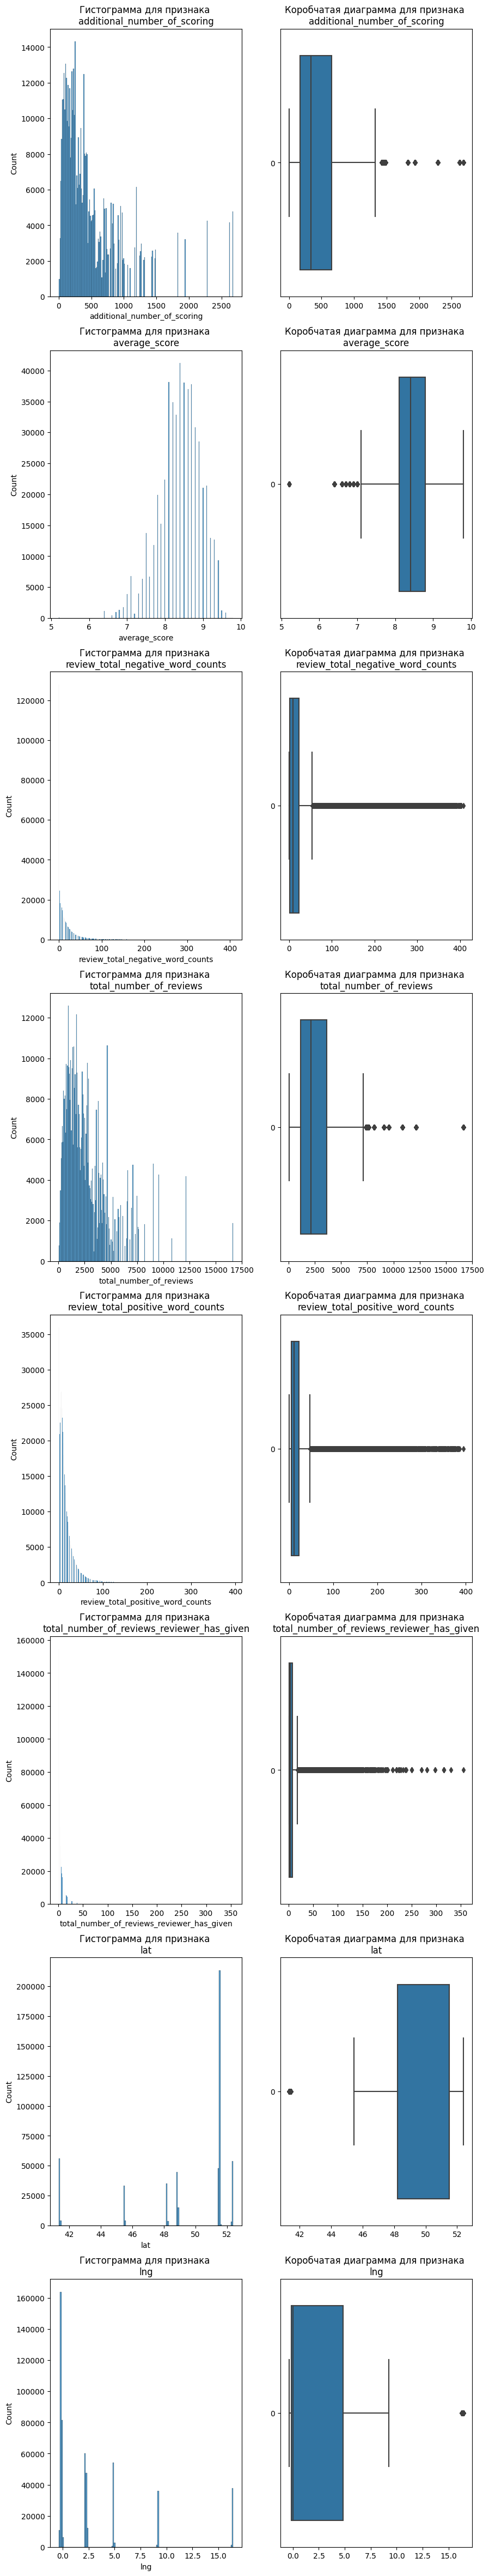

In [77]:
# Зададим полотно из двух столбцов и n строк, где n число признаков.
n = len(col)
fig, axes = plt.subplots(ncols=2, nrows=n, figsize=(10, 60))

# Пройдемся в цикле по списку столбцов и построим гистограммы и коробчатые диаграммы признаков.    
for i, col in enumerate(col):
    sns.histplot(data[col], ax=axes[i][0], label=col)
    sns.boxplot(data[col], ax=axes[i][1], orient='h')
    axes[i][0].set_title('Гистограмма для признака \n'+col) # Задаем имя графика
    axes[i][1].set_title('Коробчатая диаграмма для признака \n'+col)

### Выводы по блоку очистки данных
1. Тепловая карта и метод .info() позволяют увидеть наличие пропусков в признаках lat и lng. С помощью библиотеки geopy удалось восстановить недостающие значения координат.
2. По построенным гистограммам видно, что большинство признаков имеет распределение похожее на логнормальное. Единственный признак распределение которго похоже на нормальное - "average_score".
3. Коробчатые диаграммы (диаграммы размаха) имеют сплюснытый вид, что говорит о наличии выбросов в данных. На это же указывают точки за пределами границ распределения - "усов" (1,5 IQR). Однако, если рассуждать логически, то значения выглядящие как выбросы вполне могут быть реальными. Например, нельзя отрицать существование отелей со средним счетом 5-7 баллов. Или существование клиентов обожающих писать отзывы (более 300 оставленных ранее отзывов). Агрегаторы предложений от отелей часто проводят акции поощеряющие оставление отзывов. Также вполне вероятно наличие длинных отзывов до 400 символов в виду крайнего разочарования или восторга клиента. 

# 2 Исследование данных

In [34]:
# Сгруппируем координаты и средний счет по названиям отелей.
pivot = data.pivot_table(values=['lat', 'lng', 'average_score'], index='hotel_name', aggfunc='median')

# Построим карту с рейтингом отелей.
fig = go.Figure(go.Scattermapbox(lat=pivot['lat'],
                                 lon=pivot['lng'],
                                 mode='markers+text',
                                 marker=dict(colorbar=dict(title=dict(text='Рейтинг отелей',
                                                                      side='right'
                                                                     ),
                                                           xanchor='left',
                                                           xpad=20
                                                          ),
                                             color=pivot['average_score'],
                                             cmin=5,
                                             cmax=10,
                                             colorscale = 'spectral',
                                             size=pivot['average_score'],
                                             sizemode='area',
                                             sizeref=0.7
                                            ),
                                textposition='top right',
                                textfont=dict(size=16, color='black'),
                                text=[pivot.index[i] + '<br>' + 'Рейтинг отеля: ' +
                                      str(pivot['average_score'][i]) for i in range(pivot.shape[0])
                                      ]
                                )
                )
               
# Настроим центр карты и параметры отображения. 
map_center = go.layout.mapbox.Center(lat=45, lon=8)
fig.update_layout(mapbox_style="carto-darkmatter",
                  mapbox=dict(center=map_center, zoom=3),
                  height=500, 
                  width=1000,
                  margin=dict(r=10, b=20, t=60, l=10),
                  title=dict(text='Рейтинг отелей', x=0.5, y=0.95, font=dict(size=28))                  
                  )
fig.show()


In [79]:
#  В признаках 'positive_review' 'negative_review' присутствуют служебные значения в различных вариантах
# "No Positive","No Negative" "Location", "nothing", "N A" работающие как "заглушки" для пропусков.  
display(data[data['review_total_positive_word_counts'] < 5]['positive_review'].value_counts())
display(data[data['positive_review'] == ' Location '][['negative_review',
                                                       'positive_review',
                                                       'reviewer_score',
                                                       'review_total_negative_word_counts',
                                                       'review_total_positive_word_counts' 
                                                      ]
                                                     ].tail(3)
       )

print() # Пустая строка для отделения вывода.

# Тоже в признаке 'negative_review'.
display(data[data['review_total_negative_word_counts'] < 5]['negative_review'].value_counts())
display(data[data['negative_review'] == ' N A '][['negative_review',
                                                  'positive_review',
                                                  'reviewer_score',
                                                  'review_total_negative_word_counts',
                                                  'review_total_positive_word_counts'
                                                 ]
                                                ].tail(3)
       )

No Positive               35946
 Location                  9222
 Everything                2284
 location                  1677
 Nothing                   1243
                          ...  
 Price nice atmosphere        1
 The cleanlines               1
 Great spa facilities         1
 bed service staff            1
 Yes comfortable beds         1
Name: positive_review, Length: 17527, dtype: int64

,negative_review,positive_review,reviewer_score,review_total_negative_word_counts,review_total_positive_word_counts
514223,No Negative,Location,10.0,0,3
514684,The bedroom is very dated,Location,5.0,7,3
515087,No local shops around at night,Location,8.3,7,3


No Negative                127890
 Nothing                    14295
 Nothing                     4236
 nothing                     2225
 N A                         1037
                            ...  
 Tea making facility            1
 breakfast could richer         1
 far from uderground            1
 No usb connection              1
 Shower in bath                 1
Name: negative_review, Length: 12475, dtype: int64

,negative_review,positive_review,reviewer_score,review_total_negative_word_counts,review_total_positive_word_counts
477273,N A,The staff were highly accommodating,9.6,4,6
485567,N A,location of the site and the service is great,10.0,4,10
497493,N A,Comfortable elegant and spotless room Excelle...,10.0,4,27


In [80]:
# Значение количества слов в отзыве не всегда соответствует истине.
display(data[data['review_total_negative_word_counts'] == 2]['negative_review'].value_counts())

 Nothing         14295
 nothing          2225
 None              984
                   849
 Breakfast         407
                 ...  
 Fare                1
 neighborhood        1
 Mattrass            1
 M                   1
 Hygienic            1
Name: negative_review, Length: 920, dtype: int64

/tmp/ipykernel_25358/836257325.py:9: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



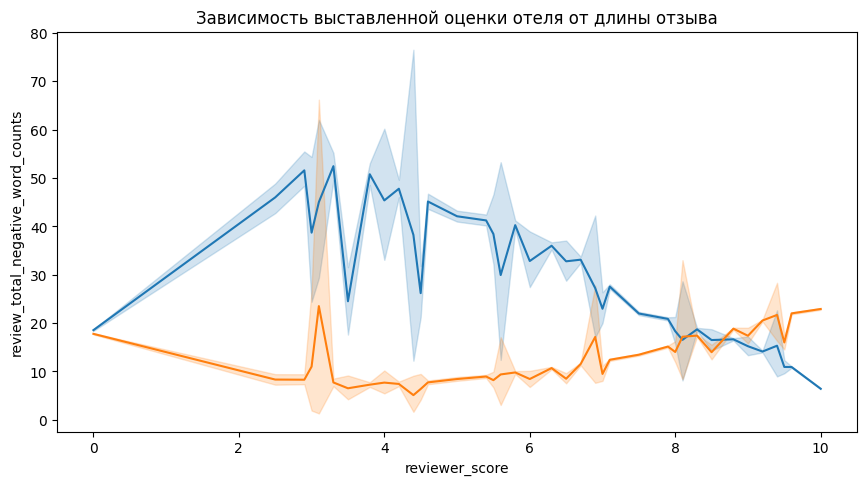

In [81]:
# Посмотрим на зависимость оценки от длины отзыва
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1,1,1,1])
ax.set_title('Зависимость выставленной оценки отеля от длины отзыва')

# Строим линейные графики для положительных и отрицательных отзывов
sns.lineplot(data, x='reviewer_score', y='review_total_negative_word_counts', ax=ax)
sns.lineplot(data, x='reviewer_score', y='review_total_positive_word_counts', ax=ax)
fig.show()


In [82]:
# Посмотрим на признак 'tags', который содержит целый список значений к тому же в виде строки.
display(data['tags'][33])

"[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']"

### Выводы по блоку исследование данных

1. У нас не очень обширная география, в данных представлены отели из шести стран Eвропы: Англия, Испания, Франция, Голландия, Австрия и Италия. Вполне вероятно, что отели в зависимости от страны имеют свой коллорит. А учитывая наличие признака национальности клиента, можно предположить, что оценка отеля будет зависить от сочетания этих признаков. Стоит попробовать выделить название страны/города из названия отелей. 
2. Стоит обратить внимание на отзывы с малым количеством слов - можно заметить, что там встречаются служебные записи типа "No Positive" или "No Negative". Эти значения судя по всему служат для заполнения пропусков. Встречаются разные формы написанния данных слов их лучше привести к одному значению. Также стоит отметить что с увеличением длины отрицательного отзыва падает и оценка отеля. Для положительных отзывов связь обратная. Однако в обоих случаях встречаются выбросы.
3. Кроме того указанное количество слов в отзыве не всегда соответствует истине. Лучше это исправить так как по сути это весовой коэффициент с ошибочными значениями. 
4. Признак даты представлен в виде строки после преобразования в дату лучше заменить его на временной интервал, например количество дней от какой-либо рассчетной временной точки.
5. Признак 'tags' содержит много информации, но в виде строки содержащей список значений. Стоит разобрать его на отдельные признаки.

#  Генерация признаков

###  3.1 Работа с географическими признаками

In [83]:
# Напишем функцию для выделения страны из полного адреса отеля.
def get_country(x):
    """Функция разделяет строку на список по пробелам и возвращает два последних элемента списка,
    разделенных пробелом, в виде строки если последний элемент был 'Kingdom'. Иначе возвращает
    последний элемент списка

    Args:
        x (str): строка с полным адресом отеля

    Returns:
        str: строка со страной отеля
    """
    a = x.split(' ')
    if a[-1] == 'Kingdom':
        return a[-2] + ' ' + a[-1]
    else:
        return a[-1]
    
# Создадим признак страны отеля
data['country'] = data['hotel_address'].apply(get_country)
display(data['country'].value_counts())

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

In [84]:
# Напишем функцию для выделения названия города из полного адреса отеля.
def get_city(x):
    """Функция разделяет строку на список по пробелам и возвращает пятый элемента списка,
    если последний элемент был 'Kingdom'. Иначе возвращает предпоследний элемент списка

    Args:
        x (str): строка с полным адресом отеля

    Returns:
        str: строка с городом отеля
    """
    a = x.split(' ')
    if a[-1] == 'Kingdom':
        return a[-5]
    else:
        return a[-2]
    
# Создадим признак города отеля.
data['city'] = data['hotel_address'].apply(get_city)
display(data['city'].value_counts())

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

In [85]:
# В признаке 'reviewer_nationality' 227 уникальных значений. Извлечем признак региона.
# Таблицу отношения стран к регионам возьмем из википедии.
url = 'https://meta.wikimedia.org/wiki/List_of_countries_by_regional_classification'
region = pd.read_html(url)[0]

# Заменим индексы датафрейма на названия стран.
region.set_index('Country', drop=True, inplace=True)

# Создадим словарь стран по регионам.
reg_dict = region['Region'].to_dict()

# Напишем функцию, возвращающую отсутствующие в словаре ключи.
def check_dict(ls_key, dict):
    """ Функиция проверяет наличие ключей из списка в словаре
    и возвращает отсутствующие в словаре ключи.

    Args:
        ls_key (list): список ключей
        dict (dict): словарь для проверки

    Returns:
        list: список отсутствующих ключей
    """
    lose_key = []
    for key in ls_key:
        if key.strip() in dict:
            continue
        else:
            lose_key.append(key)
    return lose_key

# Проверим наш словарь.
ls_key = data['reviewer_nationality'].to_list()
lose_key = check_dict(ls_key, reg_dict)
display(set(lose_key))
print() # Пустая строка для отделения вывода.

# Фиксим отсутствующие значения в словаре.
reg_dict['unknown'] = 'unknown'
reg_dict['United States of America'] = 'North America'
reg_dict['Iran'] = 'Middle east'
reg_dict['South Korea'] = 'Asia & Pacific'
reg_dict['Russia'] = 'Europe' 
reg_dict['Brunei'] = 'Asia & Pacific'
reg_dict['Kosovo'] = 'Europe'
reg_dict['Abkhazia Georgia'] = 'Europe'
reg_dict['Syria'] = 'Asia & Pacific'
reg_dict['Moldova'] = 'Europe'
reg_dict['Tanzania'] = 'Africa'
reg_dict['Ivory Coast'] = 'Africa'
reg_dict['Cura ao'] = 'South/Latin America'
reg_dict['U S Virgin Islands'] = 'South/Latin America'
reg_dict['Falkland Islands Malvinas'] = 'South/Latin America'
reg_dict['Turks Caicos Islands'] = 'South/Latin America'
reg_dict['Laos'] = 'Asia & Pacific'
reg_dict['Crimea'] = 'Europe'
reg_dict['St Maarten'] = 'North America'
reg_dict['British Virgin Islands'] = 'South/Latin America'
reg_dict['Antigua Barbuda'] = 'South/Latin America'
reg_dict['St Pierre and Miquelon'] = 'North America'
reg_dict['Cocos K I'] = 'Asia & Pacific'
reg_dict['Swaziland'] = 'Africa'
reg_dict['Saint Vincent Grenadines'] = 'South/Latin America'
reg_dict['Bonaire St Eustatius and Saba'] = 'South/Latin America'
reg_dict['Democratic Republic of the Congo'] = 'Africa'
reg_dict['East Timor'] = 'Asia & Pacific'
reg_dict['Svalbard Jan Mayen'] = 'Europe'
reg_dict['Saint Barts'] = 'North America'
reg_dict['Central Africa Republic'] = 'Africa'
reg_dict['Vatican City'] = 'Europe'

# Заменяем пустые строки на 'unknown' и убираем пробелы в начале и в конце остальных названий.
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'unknown' if x == ' ' else x.strip())

# Определяем регион гостя оставившего отзыв по стране происхождения.  
data['reviewer_region'] = data['reviewer_nationality'].apply(lambda x: reg_dict[x])
display(f"Количество уникальных значений в признаке 'reviewer_region': {data['reviewer_region'].nunique()}")

{' ',
 ' Abkhazia Georgia ',
 ' Antigua Barbuda ',
 ' Bonaire St Eustatius and Saba ',
 ' British Virgin Islands ',
 ' Brunei ',
 ' Central Africa Republic ',
 ' Cocos K I ',
 ' Crimea ',
 ' Cura ao ',
 ' Democratic Republic of the Congo ',
 ' East Timor ',
 ' Falkland Islands Malvinas ',
 ' Iran ',
 ' Ivory Coast ',
 ' Kosovo ',
 ' Laos ',
 ' Moldova ',
 ' Russia ',
 ' Saint Barts ',
 ' Saint Vincent Grenadines ',
 ' South Korea ',
 ' St Maarten ',
 ' St Pierre and Miquelon ',
 ' Svalbard Jan Mayen ',
 ' Swaziland ',
 ' Syria ',
 ' Tanzania ',
 ' Turks Caicos Islands ',
 ' U S Virgin Islands ',
 ' United States of America ',
 ' Vatican City '}

"Количество уникальных значений в признаке 'reviewer_region': 9"

In [86]:
# Попробуем определить координаты страны происхождения клиента.
# Создаем датафрейм с уникальными значениями стран.
df = pd.DataFrame(columns=['nationality', 'loc_nationality'])
df['nationality'] = data['reviewer_nationality'].unique()

# С определением координат Палестины проблемы из-за разных названий в данных и геокодере, исправим это.
# Кроме того придется заменить значение 'unknown' на ' ', иначе геокодер выдает координаты Восточной Явы.
df['nationality'] = df['nationality'].replace({'unknown':' ','Palestinian Territory':'Palestinian Territories'})
            
# Используем геокодер Nominatim.
geolocator = Nominatim(user_agent="Test", timeout=10) # Для работы нужно указать название приложения.
#timeout=1 # Зададим задержку в 1 секунду, если ее не задавать иногда выскакивает ошибка.
# Найдем координаты страны происхождения каждого клиента с помощью метода .geocode(). 
df['loc_nationality'] = df['nationality'].apply(lambda x: geolocator.geocode(x))

# В данных осталвсь одна пустая строка с неуказанной странной: ' '. 
# Заменим координаты на координаты самой популярной страны: 'United Kingdom'.
df['loc_nationality'][35] = df['loc_nationality'][0]

# Заменим пустое значение на 'unknown'.
df['nationality'] = df['nationality'].replace({' ':'unknown'})

# Создадим признаки с широтой и долготой страны происхождения клиента.
df['lat_reviewer'] = df['loc_nationality'].apply(lambda x: x.latitude)
df['lng_reviewer'] = df['loc_nationality'].apply(lambda x: x.longitude)

# Удалим признак с координатами.
df.drop(['loc_nationality'], axis=1, inplace=True)

# Заменим индексы датафрейма на названия стран.
df.set_index('nationality', drop=True, inplace=True)

# Создадим словари с широтой и долготой страны происхождения клиента.
lat_dict = df['lat_reviewer'].to_dict()
lng_dict = df['lng_reviewer'].to_dict()

# Исправим название Палестины.
data['reviewer_nationality'].replace({'Palestinian Territory':'Palestinian Territories'}, inplace=True)

# Создадим новые признаки с координатами обратившись к созданным словарям по названию стран.
data['rev_lat'] = data['reviewer_nationality'].apply(lambda x: lat_dict[x])
data['rev_lng'] = data['reviewer_nationality'].apply(lambda x: lng_dict[x]) 



###  3.2 Работа с отзывами

In [87]:
# Исправим значения признака 'negative_review', удалив пробелы в начале и конце строки.
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip())

# Создадим список значений-заглушек для признака 'negative_review'.
neg_ls = ['No Negative', 'nothing', 'N A', 'Nothing', 'None', 'N a', 'All good', 'Nothing really']

# Исправим признак 'negative_review' заменив значения заглушки на одно значение 'N/A'.
data['negative_review'] = data['negative_review'].apply(lambda x: 'N/A' if x in neg_ls else x)


# Повторим для признака 'positive_review'.
# Удалим пробелы в начале и конце значений.
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip())

# Создадим список значений-заглушек для признака 'positive_review'.
pos_ls = ['No Positive', 'Nothing']

# Исправим признак 'positive_review' заменив значения заглушки на одно значение 'N/A'.
data['positive_review'] = data['positive_review'].apply(lambda x: 'N/A' if x in pos_ls else x)


# Поправим признаки количества слов в отзыве заменив значения на длину строки с отзывом.
data['review_total_negative_word_counts'] = data['negative_review'].apply(len)
data['review_total_positive_word_counts'] = data['positive_review'].apply(len)

# Оценим эмоцианальную окраску отзывов с помощью библиотеки SentimentIntensityAnalyzer.
sent_analyzer = SentimentIntensityAnalyzer()
data['score_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['score_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# Создадим отдельные признаки из результатов оценки, обратившись по ключу словаря.
data['score_neg_neg'] = data['score_neg'].apply(lambda x: x['neg'])
data['score_neg_neu'] = data['score_neg'].apply(lambda x: x['neu'])
data['score_neg_pos'] = data['score_neg'].apply(lambda x: x['pos'])
data['score_neg_compound'] = data['score_neg'].apply(lambda x: x['compound'])

data['score_pos_neg'] = data['score_pos'].apply(lambda x: x['neg'])
data['score_pos_neu'] = data['score_pos'].apply(lambda x: x['neu'])
data['score_pos_pos'] = data['score_pos'].apply(lambda x: x['pos'])
data['score_pos_compound'] = data['score_pos'].apply(lambda x: x['compound'])

# Удалим словари с результатом оценки и признаки с отзывами.
data.drop(['score_neg','score_pos', 'negative_review', 'positive_review'], axis=1, inplace=True)

### 3.3 Работа с датами

In [88]:
# Преобразуем дату в тип данных datetime.
data['review_date'] = pd.to_datetime(data['review_date'])

# За текущую дату примем 1 января 2018 года.
now_date = pd.to_datetime('2018-01-01')

# Создадим признак количества дней, прошедших со дня оставления отзыва. 
data['review_days'] = data['review_date'].apply(lambda x: (now_date - x).days)

# Создадим признак месяца проживания выделив из признака 'review_date' значение месяца.
data['month'] = data['review_date'].dt.month

# Признак 'days_since_review' состоит из строк с количеством дней, извлечем из строк числа
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

# Удаляем исходный признак.
data.drop(['review_date'], axis=1, inplace=True)

###  3.4 Работа с тегами

In [89]:
# Преобразуем значения признака  'tags' из строк в список, раздели по символу одиночных кавычек.
# Возьмем срез без первого и последнего элемента с шагом 2, чтобы избавится от оставшихся символов 
# квадратных скобок и запятых между значениями тегов.
data['tags'] = data['tags'].apply(lambda x: x.split("'")[1:-1:2])

# Определим максимальное количество тэгов.
length = data.copy()
length['len'] = length['tags'].apply(len)
display(f"Максимальное количество тэгов: {length['len'].max()}")
print() # Пустая строка для отделения выводов.

# Посмотрим на структуру тэгов.
display(length[length['len'] == 6]['tags'].iloc[698])

'Максимальное количество тэгов: 6'

[' With a pet ',
 ' Leisure trip ',
 ' Family with young children ',
 ' King Guest Room ',
 ' Stayed 1 night ',
 ' Submitted from a mobile device ']

In [90]:
# Напишем функцию для разделения тегов.
def g_tag(x, string):
    """Функция ищет в каждом элемента списка заданную подстроку, 
    если находит - возвращает этот элемент. Иначе возвращает None.

    Args:
        x (list): список строк для поиска заданной подстроки
        string (str): искомая подстрока

    Returns:
        str, None: элемент списка или None
    """
    for i in x:
        # Метод строки .find() возвращает -1 если не находит заданную подстроку.
        if i.find(string) != -1:
            return i
        
# Выделим тэг наличия питомца в отдельный признак.
data['tag_pet'] = data['tags'].apply(lambda x: g_tag(x, 'pet'))

# Выделим тэг цели поездки в отдельный признак.
data['tag_trip'] = data['tags'].apply(lambda x: g_tag(x, 'trip'))

# Выделим тэг длительности проживания в отеле в отдельный признак.
data['cnt_nights'] = data['tags'].apply(lambda x: g_tag(x, 'Stayed'))

# Выделим тэг способа отправки отзыва в отдельный признак. 
data['submit_rev'] = data['tags'].apply(lambda x: g_tag(x, 'Submit'))

# Тэг количества гостей содержит несколько возможных значений (соло, с детьми, пара, группа)
# Для выделения этого тега нпишем функцию поиска тега по нескольким условиям.
def g_tag_traveler(x):
    """Функция ищет в каждом элемента списка одну из заданных подстрок
    ('ravel', 'children', 'Couple', 'Group'), если находит - возвращает
    этот элемент. Иначе возвращает None.

    Args:
        x (list): список строк для поиска заданных подстрок        

    Returns:
        str, None: элемент списка или None
    """
    for i in x:
        if (i.find('ravel') != -1) or (i.find('children') != -1) or (i.find('Couple') != -1) or (i.find('Group') != -1):
            return i
        
# Выделим тэг количества гостей в отдельный признак.
data['type_traveler'] = data['tags'].apply(g_tag_traveler)

# Последний тег тип номера содержит множество вариантов. Для его выделения исключим из исходного признака 'tags'
# все выделенные в отдельные признаки теги.
data.apply(lambda x: x['tags'].remove(x['tag_pet']) if x.tag_pet in x.tags else x['tags'], axis=1)
data.apply(lambda x: x['tags'].remove(x['tag_trip']) if x.tag_trip in x.tags else x['tags'], axis=1)
data.apply(lambda x: x['tags'].remove(x['cnt_nights']) if x.cnt_nights in x.tags else x['tags'], axis=1)
data.apply(lambda x: x['tags'].remove(x['submit_rev']) if x.submit_rev in x.tags else x['tags'], axis=1)
data.apply(lambda x: x['tags'].remove(x['type_traveler']) if x.type_traveler in x.tags else x['tags'], axis=1)

# Преобразуем значения признака 'tags' из списка в строку.
data['tags'] = data['tags'].apply(''.join)

# Переименуем признак.
data = data.rename({'tags':'type_room'}, axis=1)

# Уберем пустые строки ('') в признаке 'type_room'.
data['type_room'] = data['type_room'].apply(lambda x: 'unknown' if x == '' else x)

# Преобразуем признак 'tag_pet', заменив значения на 0 и 1.
data['tag_pet'] = data['tag_pet'].apply(lambda x: 1 if x==' With a pet ' else 0)

#  Преобразуем признак 'submit_rev', заменив значения на 0 и 1.
data['submit_rev'] = data['submit_rev'].apply(lambda x: 1 if x==' Submitted from a mobile device ' else 0)

# Заполним пропуски в признаке 'tag_trip' на 'unknown'.
data['tag_trip'].fillna('unknown', inplace=True)

# Заполним пропуски в признаке 'cnt_nights' на моду данного признака.
data['cnt_nights'] = data['cnt_nights'].fillna(data['cnt_nights'].mode()[0])

# Выделим количество ночей из признака 'cnt_nights'.
data['cnt_nights'] = data['cnt_nights'].apply(lambda x: int((re.findall(r'\d+', x)[0])))

###  3.5 Кодирование признаков

In [91]:
# Определим список признаков с типом данных 'object' и небольшим количеством уникальных значений.
ls_for_dummies = [s for s in data.columns if data[s].dtypes == 'object' and data[s].nunique() < 15]

# Применим однократное кодирование к признакам с небольшим количеством уникальных значений.
data = pd.get_dummies(data, columns=ls_for_dummies)

# Определим список признаков с типом данных 'object' и большим количеством уникальных значений.
ls_for_bin = [s for s in data.columns if data[s].dtypes == 'object' and data[s].nunique() >= 15]

# Применяем бинарное кодирование для признаков с большим количеством уникальных значений.
bin_encoder = ce.BinaryEncoder(cols=ls_for_bin)
val_bin = bin_encoder.fit_transform(data[ls_for_bin])

# Присоединим к исходному датасету результаты бинарного кодирования.
data = pd.concat([data, val_bin], axis=1)

# Удалим исходные признаки
data.drop(ls_for_bin, axis=1, inplace=True)


In [110]:
# Посмотрим на итоговое количество признаков.
print(f'В итоговом наборе данных {data.shape[1]} признаков')

В итоговом наборе данных 98 признаков


###  Выводы по блоку генерация признаков
1. Созданы новые признаки страна отеля, город отеля, координат страны происхождения и региона клиента. Признак страны и города отеля скорее всего имеют сильную корреляцию между собой и координатами отеля возможно придется исключить некоторые из этих признаков.
2. Значения заглушки в признаке с отзывами заменены на единое значение. Испрален признак с количеством слов в отзыве путем замены на длину отзыва. С помощью библиотеки SentimentIntensityAnalyzer проведена оценка эмоцианальной окраски отзывов и получено 8 новых числовых признака.
3. Проведена работа с датами: дата отзыва заменена на количество прошедших дней, выделен признак месяца оставления отзыва, а также выделено количество дней между датой проверки отзыва и датой очистки.
4. Проведено разделение и преобразование тегов в шесть отдельных признаков. 
5. Применено однократное и бинарное (для признаков с количеством уникальных значений больше 14) кодирование. В результате получено 98 числовых признака.


#  4. Преобразование признаков

###  4.1 Нормализация методом MinMaxScaler

In [93]:
# Создадим список имен столбцов и уберем из него целевой признак и признак-метку.
col_names = list(data.columns)
col_names.remove('reviewer_score')
col_names.remove('sample')

# Создадим датафрейм для нормализации методом MinMaxScaler без целевого признака и признака-метки.
df_mm = data.drop(['reviewer_score', 'sample'], axis=1)

# Проводим нормализацию. 
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(df_mm)

# Преобразуем результат в датафрейм и возращаем имена столбцов.
df_mm = pd.DataFrame(df_mm, columns=col_names)

# Возвращаем удаленные столбцы. 
df_mm = pd.concat([df_mm, data[['reviewer_score', 'sample']]], axis=1)

###  4.2 Нормализация методом RobustScaler

In [94]:
# Создадим датафрейм для нормализации методом RobustScaler без целевого признака и признака-метки.
df_r = data.drop(['reviewer_score', 'sample'], axis=1)

# Проводим нормализацию. 
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(df_r)

# Преобразуем результат в датафрейм и возращаем имена столбцов.
df_r = pd.DataFrame(df_r, columns=col_names)

# Возвращаем удаленные столбцы. 
df_r = pd.concat([df_r, data[['reviewer_score', 'sample']]], axis=1)

###  4.3 Стандартизация

In [95]:
# Создадим датафрейм для стандартизации методом StandardScaler без целевого признака и признака-метки.
df_s = data.drop(['reviewer_score', 'sample'], axis=1)

# Проводим нормализацию. 
s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df_s)

# Преобразуем результат в датафрейм и возращаем имена столбцов.
df_s = pd.DataFrame(df_s, columns=col_names)

# Возвращаем удаленные столбцы. 
df_s = pd.concat([df_s, data[['reviewer_score', 'sample']]], axis=1)


### 4.4 Комбинации преобразований

In [96]:
# Стандартизация после нормализации:
# Cтандартизируем данные после нормализации методом MinMaxScaler.
df_s_mm = df_mm.drop(['reviewer_score', 'sample'], axis=1)

# Проводим стандартизацию. 
df_s_mm = s_scaler.fit_transform(df_s_mm)

# Преобразуем результат в датафрейм и возращаем имена столбцов.
df_s_mm = pd.DataFrame(df_s_mm, columns=col_names)

# Возвращаем удаленные столбцы. 
df_s_mm = pd.concat([df_s_mm, data[['reviewer_score', 'sample']]], axis=1)

# Cтандартизируем данные после нормализации методом RobustScaler
df_s_r = df_r.drop(['reviewer_score', 'sample'], axis=1)

# Проводим стандартизацию. 
df_s_r = s_scaler.fit_transform(df_s_r)

# Преобразуем результат в датафрейм и возращаем имена столбцов.
df_s_r = pd.DataFrame(df_s_r, columns=col_names)

# Возвращаем удаленные столбцы. 
df_s_r = pd.concat([df_s_r, data[['reviewer_score', 'sample']]], axis=1)

# Нормализация после стандартизации:
# Нормализуем данные методом MinMaxScaler после стандартизации.
df_mm_s = df_s.drop(['reviewer_score', 'sample'], axis=1)

# Проводим нормализацию. 
df_mm_s = mm_scaler.fit_transform(df_mm_s)

# Преобразуем результат в датафрейм и возращаем имена столбцов.
df_mm_s = pd.DataFrame(df_mm_s, columns=col_names)

# Возвращаем удаленные столбцы. 
df_mm_s = pd.concat([df_mm_s, data[['reviewer_score', 'sample']]], axis=1)

#  Нормализуем данные методом RobustScaler после стандартизации.
df_r_s = df_s.drop(['reviewer_score', 'sample'], axis=1)

# Проводим нормализацию. 
df_r_s = r_scaler.fit_transform(df_r_s)

# Преобразуем результат в датафрейм и возращаем имена столбцов.
df_r_s = pd.DataFrame(df_r_s, columns=col_names)

# Возвращаем удаленные столбцы. 
df_r_s = pd.concat([df_r_s, data[['reviewer_score', 'sample']]], axis=1)


###  Выводы по блоку преобразование признаков
Применены методы преборазования признаков - нормализация (MinMaxScaler и RobustScaler) и стандартизация (StandardScaler). Методы применялись поодиночке и в комбинации. В результате преобразования получено семь наборов данных.

#  5 Отбор признаков

<AxesSubplot: >

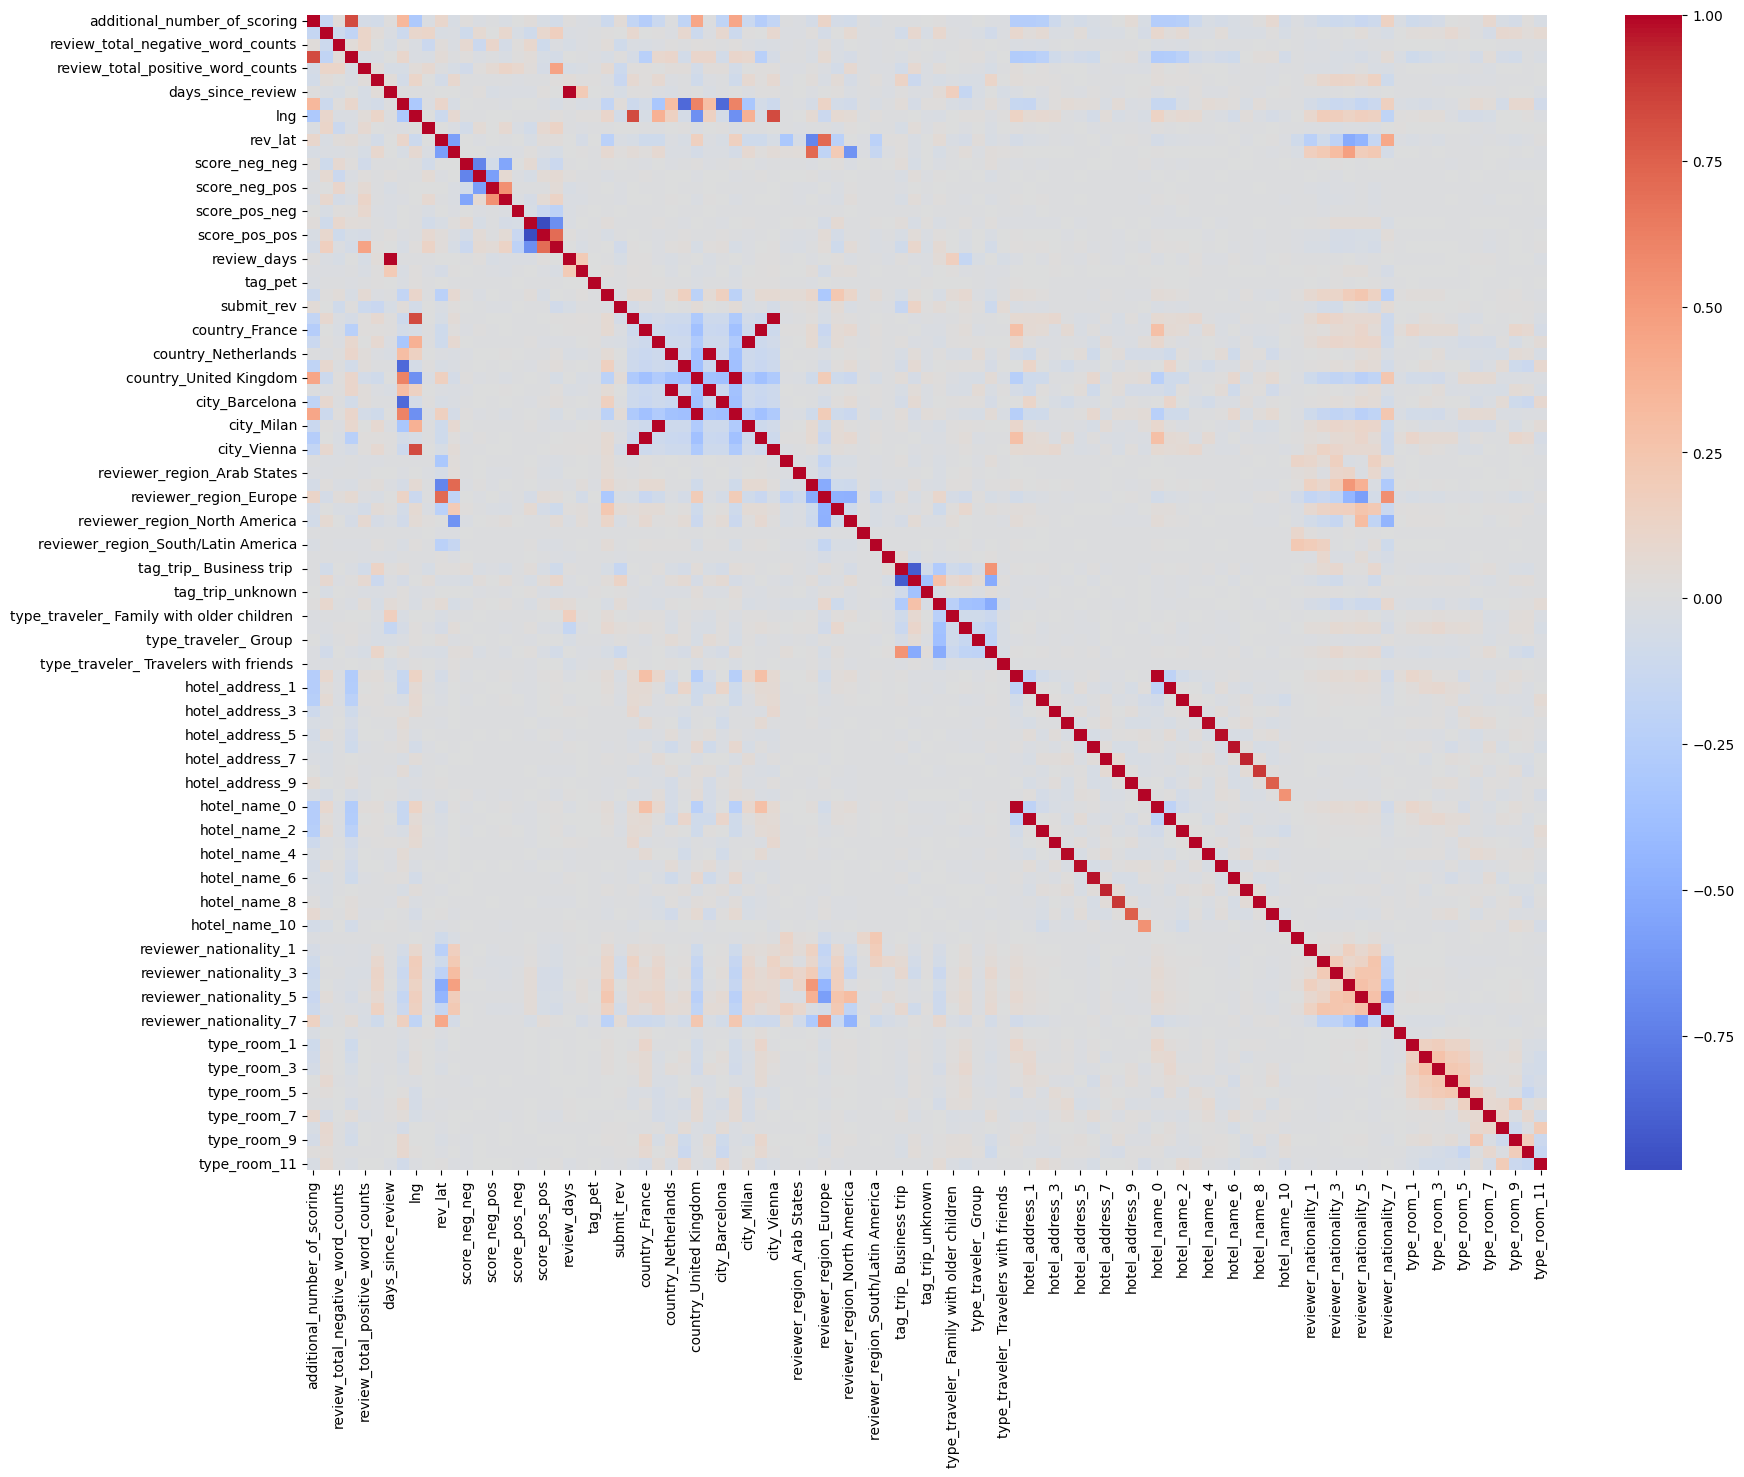

In [97]:
# Построим матрицу корреляции признаков.
plt.rcParams['figure.figsize'] = (20,15)

# Признаков очень много, поэтому не будем выводить числовые аннотации.
sns.heatmap(data.drop(['sample'], axis=1).corr(), cmap="coolwarm")

In [98]:
# Разделим признаки на непрерывные и категориальные.
# Непрерывные признаки.
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
            'additional_number_of_scoring', 'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'cnt_nights'
           ]

# Категориальные признаки.
cat_cols = ['average_score', 'lat', 'score_neg_neg', 'score_neg_neu', 'score_neg_pos', 
            'score_pos_neg', 'score_pos_neu', 'score_pos_pos', 'review_days', 
            'month', 'tag_pet', 'submit_rev', 'country_Austria', 'country_France',
            'country_Italy', 'country_Netherlands', 'country_Spain', 'country_United Kingdom',
            'city_Amsterdam', 'city_Barcelona', 'city_London', 'city_Milan', 'city_Paris',
            'city_Vienna', 'reviewer_region_Africa', 'reviewer_region_Arab States',
            'reviewer_region_Asia & Pacific', 'reviewer_region_Europe','reviewer_region_Middle east',
            'reviewer_region_North America','reviewer_region_South/Central America',
            'reviewer_region_South/Latin America', 'reviewer_region_unknown',
            'tag_trip_ Business trip ', 'tag_trip_ Leisure trip ', 'tag_trip_unknown',
            'type_traveler_ Couple ', 'type_traveler_ Family with older children ',
            'type_traveler_ Family with young children ', 'type_traveler_ Group ',
            'type_traveler_ Solo traveler ', 'type_traveler_ Travelers with friends ',
            'hotel_address_0', 'hotel_address_1', 'hotel_address_2', 'hotel_address_3',
            'hotel_address_4', 'hotel_address_5', 'hotel_address_6', 'hotel_address_7',
            'hotel_address_8', 'hotel_address_9', 'hotel_address_10', 'hotel_name_0', 
            'hotel_name_1', 'hotel_name_2', 'hotel_name_3', 'hotel_name_4', 'hotel_name_5',
            'hotel_name_6', 'hotel_name_7', 'hotel_name_8', 'hotel_name_9', 'hotel_name_10',
            'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 
            'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5',
            'reviewer_nationality_6', 'reviewer_nationality_7', 'type_room_0', 'type_room_1', 
            'type_room_2', 'type_room_3', 'type_room_4', 'type_room_5', 'type_room_6', 
            'type_room_7', 'type_room_8', 'type_room_9', 'type_room_10', 'type_room_11',
            'rev_lat', 'rev_lng', 'lng', 'score_pos_compound'
            ]

# Разделим данные по признаку метке.
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data['reviewer_score'] # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

<AxesSubplot: >

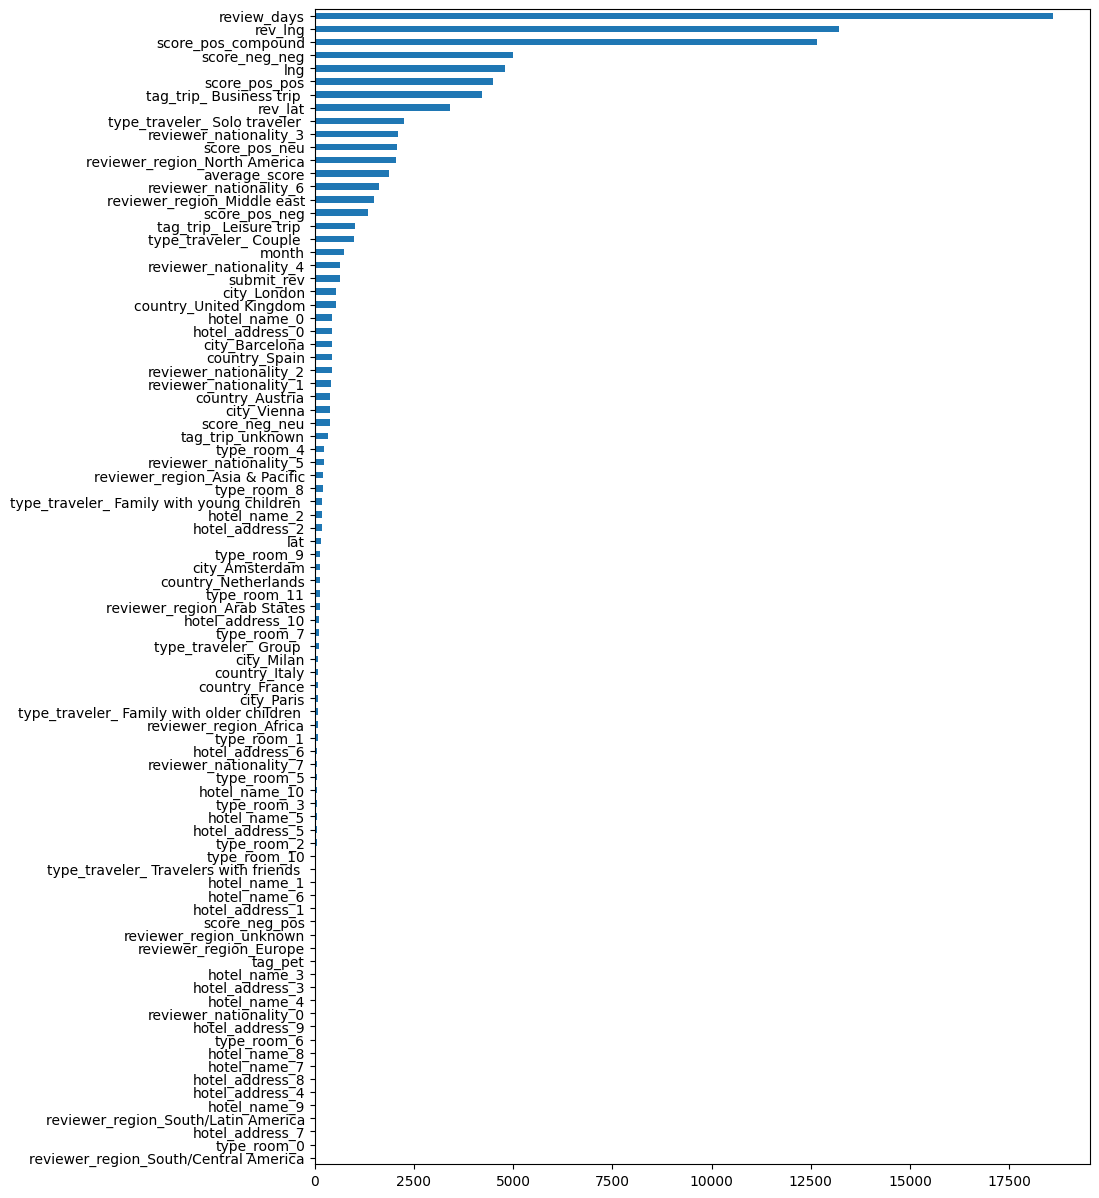

In [99]:
# Построим график важности категориальных признаков.
# Тест хи квадрат не принимает отрицательные значения, поэтому возьмем их модуль.
X_abs = X.apply(lambda x: abs(x))

# Целевой признак преобразуем в целые числа, на float тест ругается.
y_chi2 = y.astype('int') 

plt.rcParams['figure.figsize'] = (10,15)
imp_cat = pd.Series(chi2(X_abs[cat_cols], y_chi2)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot: >

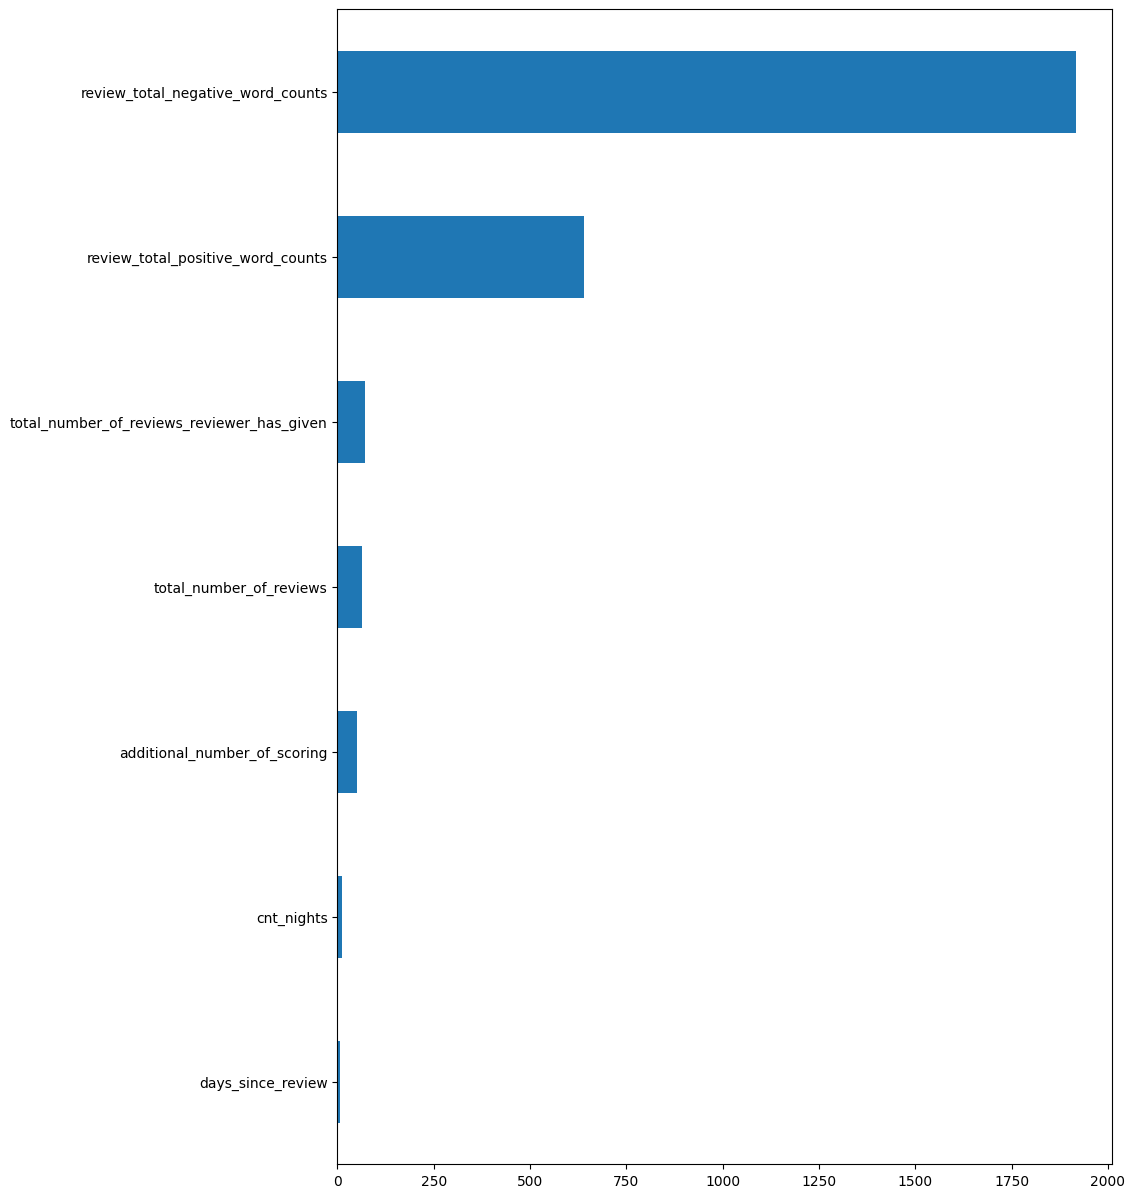

In [100]:
# Построим график важности номинальных признаков
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [ ]:
# Итак у нас получилось 8 наборов данных с разными вариантами преобразования.
df_t = [data, df_mm, df_r, df_s, df_s_mm, df_s_r, df_mm_s, df_r_s]

# Напишем функцию для проверки какой тип преобразования в данном случае лучше.
def test(df_ls):
    """Функиция проводит отбор наиболее важных из признаков с высокой корреляцией для различных вариантов 
    преобразований данных. Обучает модель, делает предсказание с помощью обученной модели 
    и возвращает список значений метрики для каждого из входящих наборов данных.
   
    Args:
        df_ls (list): список, содержащий наборы данных для тестирования.
        
    Returns:
        list: список значений метрики MAPE для каждого из входящих в df_ls наборов данных.
    """
    ls_result = []
    for df in df_ls:
        # Проведем поиск признаков с сильной корреляцией.
        corr = df.drop(['sample', 'reviewer_score'], axis=1).corr()
        
        # Создадим датафрейм-маску: для значений с коэффициентом корреляции больше или меньше 0,7 - значение True.
        score = corr.apply(lambda x: ((x > 0.7) | (x < -0.7)), axis=1)
        
        # Пройдем в цикле по строкам и столбцам полученного датафрейма и поместим признаки с сильной корреляцией в список.
        ls_cor = list() 
        for i in score.index:
            for j in score.columns:
                if (score.loc[i][j]) and (i != j):
                    ls_cor.append([i, j, str(round(corr.loc[i][j], 2))])
                      
        # Разделим признаки на непрерывные и категориальные.
        # Непрерывные признаки.
        num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts',
                    'additional_number_of_scoring', 'review_total_positive_word_counts', 
                    'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'cnt_nights'
                   ]
        # Категориальные признаки.
        cat_cols = ['average_score', 'lat', 'score_neg_neg', 'score_neg_neu', 'score_neg_pos', 
                    'score_pos_neg', 'score_pos_neu', 'score_pos_pos', 'review_days', 
                    'month', 'tag_pet', 'submit_rev', 'country_Austria', 'country_France',
                    'country_Italy', 'country_Netherlands', 'country_Spain', 'country_United Kingdom',
                    'city_Amsterdam', 'city_Barcelona', 'city_London', 'city_Milan', 'city_Paris',
                    'city_Vienna', 'reviewer_region_Africa', 'reviewer_region_Arab States',
                    'reviewer_region_Asia & Pacific', 'reviewer_region_Europe','reviewer_region_Middle east',
                    'reviewer_region_North America','reviewer_region_South/Central America',
                    'reviewer_region_South/Latin America', 'reviewer_region_unknown',
                    'tag_trip_ Business trip ', 'tag_trip_ Leisure trip ', 'tag_trip_unknown',
                    'type_traveler_ Couple ', 'type_traveler_ Family with older children ',
                    'type_traveler_ Family with young children ', 'type_traveler_ Group ',
                    'type_traveler_ Solo traveler ', 'type_traveler_ Travelers with friends ',
                    'hotel_address_0', 'hotel_address_1', 'hotel_address_2', 'hotel_address_3',
                    'hotel_address_4', 'hotel_address_5', 'hotel_address_6', 'hotel_address_7',
                    'hotel_address_8', 'hotel_address_9', 'hotel_address_10', 'hotel_name_0', 
                    'hotel_name_1', 'hotel_name_2', 'hotel_name_3', 'hotel_name_4', 'hotel_name_5',
                    'hotel_name_6', 'hotel_name_7', 'hotel_name_8', 'hotel_name_9', 'hotel_name_10',
                    'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 
                    'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5',
                    'reviewer_nationality_6', 'reviewer_nationality_7', 'type_room_0', 'type_room_1', 
                    'type_room_2', 'type_room_3', 'type_room_4', 'type_room_5', 'type_room_6', 
                    'type_room_7', 'type_room_8', 'type_room_9', 'type_room_10', 'type_room_11',
                    'rev_lat', 'rev_lng', 'lng', 'score_pos_compound'
                   ] 
   
        
        # Разделим данные по признаку метке.
        train_data = df.query('sample == 1').drop(['sample'], axis=1)
        test_data = df.query('sample == 0').drop(['sample'], axis=1)
        
        y = train_data['reviewer_score'] # наш таргет.    
        X = train_data.drop(['reviewer_score'], axis=1)
                     
        # Оценим важность признаков.
        y_chi2 = y.astype('int')
        X_abs = X.apply(lambda x: abs(x))
        imp_cat = pd.Series(chi2(X_abs[cat_cols], y_chi2)[0], index=cat_cols)
        imp_num = pd.Series(f_classif(X[num_cols], y_chi2)[0], index=num_cols)
        
        # Объединим результаты оценки важности признаков в одну Series.
        ls_feature = pd.concat([imp_num, imp_cat], sort=True)
                
        # Создадим список признаков подлежащих исключению, выбрав из двух признаков с
        # сильной корреляцией тот что менeе важен по результатам статистических тестов.
        drop_ls = []
        for i in ls_cor:
            if ls_feature[i[0]] <= ls_feature[i[1]]:
                drop_ls.append(i[0])
            else:
                drop_ls.append(i[1])
        
        # Уберем повторы, преобразовав в множество и вернемся к списку для возможности 
        # перебора значений по индексам.
        drop_ls = (list(set(drop_ls)))
        
        # Создадим список всех признаков.
        ls_all = ls_feature.sort_values().index.values.tolist()
        
        # Удалим признаки с сильной корреляцией из нашего списка.
        for i in drop_ls:
            ls_all.remove(i)
            
        # Делим тренирововчную выборку на данные для обучения и проверки модели.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
            
        # Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ).
        model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
            
        # Обучаем модель на тестовом наборе данных.
        model.fit(X_train[ls_all], y_train)
            
        # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
        # Предсказанные значения записываем в переменную y_pred.
        y_pred = model.predict(X_test[ls_all])
            
        # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
        mape = np.mean(np.abs((y_test - y_pred)/y_test))*100 
        
        ls_result.append(mape)
        
    return ls_result

# Посмотрим на результат отбора.
display(test(df_t))    

[12.349121206249155,
 12.446974911061218,
 12.350192627086091,
 12.46681844783078,
 12.46681844783078,
 12.46681844783078,
 12.446974911061218,
 12.36858319749947]

### Выводы по блоку отбор признаков
1. Матрица корреляции показывает, что у нас есть признаки с сильной корреляцией (коэффициент более +/- 0,7) и даже признаки с мультиколлинераностью. Это признаки страны и города отеля, а также название и адрес отеля. Можно избавиться от одного признака в каждой паре.
2. По графику важности категориальных признаков видно, что наиболее важным признаком в определении рейтинга отеля является признак даты отзыва (это неожидано). Далее идут признаки счета эмоциональной оценки отзыва, типа поездки, национальности клиента, города/страны отеля.
3. По  графику важности номинальных признаков видно, что наиболее важным признаком в определении рейтинга отеля является признак длины отзыва. Причем как отмечалось ранее длина отрицательного отзыва играет большую роль. Далее идут признаки количества оставленных отзывов, общего количества действительных отзывов об отеле, количества действительных оценок без проверки.
4. Работа функции test показала, что наилучший результат достигается на наборе данных без преобразований - 12,349. Чуть хуже результат c преобразованием RobustScaler - 12,35. Применение остальных преобразований ухудшает метрику МАРЕ. 

#   6. Обучение модели 

In [ ]:
# Используем датасет без преобразований.
# Повторим процедуру отбора признаков.
# Проведем поиск признаков с сильной корреляцией.
corr = data.drop(['sample', 'reviewer_score'], axis=1).corr()
        
# Создадим датафрейм-маску: для значений с коэффициентом корреляции больше или меньше 0,7 - значение True.
score = corr.apply(lambda x: ((x > 0.7) | (x < -0.7)), axis=1)
        
# Пройдем в цикле по строкам и столбцам полученного датафрейма и поместим признаки с сильной корреляцией в список.
ls_cor = list() 
for i in score.index:
    for j in score.columns:
        if (score.loc[i][j]) and (i != j):
            ls_cor.append([i, j, str(round(corr.loc[i][j], 2))])

# Разделим данные по признаку метке.
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
        
y = train_data['reviewer_score'] # наш таргет    
X = train_data.drop(['reviewer_score'], axis=1)
       
# Оценим важность признаков.
y_chi2 = y.astype('int')        
X_abs = X.apply(lambda x: abs(x))
imp_cat = pd.Series(chi2(X_abs[cat_cols], y_chi2)[0], index=cat_cols)
imp_num = pd.Series(f_classif(X[num_cols], y_chi2)[0], index=num_cols)
        
# Объединим результаты оценки важности признаков в одну Series.
ls_feature = pd.concat([imp_num, imp_cat], sort=True)
                
# Создадим список признаков подлежащих исключению, выбрав из двух признаков с
# сильной корреляцией тот что менeе важен по результатам статистических тестов.
drop_ls = []
for i in ls_cor:
    if ls_feature[i[0]] <= ls_feature[i[1]]:
        drop_ls.append(i[0])
    else:
        drop_ls.append(i[1])

# Уберем повторы, преобразовав в множество и вернемся к списку для возможности 
# перебора значений по индексам.
drop_ls = (list(set(drop_ls)))

# Создадим копию датасета и уберем признаки признаки с высокой корреляцией.
df = data.copy()
df.drop(drop_ls, inplace=True, axis=1)

# Разделим данные по признаку метке.
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data['reviewer_score'] # наш таргет    
X = train_data.drop(['reviewer_score'], axis=1)

# Делим тренирововчную выборку на данные для обучения и проверки модели.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ).
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)          

# Обучаем модель на тестовом наборе данных.
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred.
y_pred = model.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
mape = np.mean(np.abs((y_test - y_pred)/y_test))*100 

# Выводим значение метрики.
print(mape)

12.330421169440601


<AxesSubplot:>

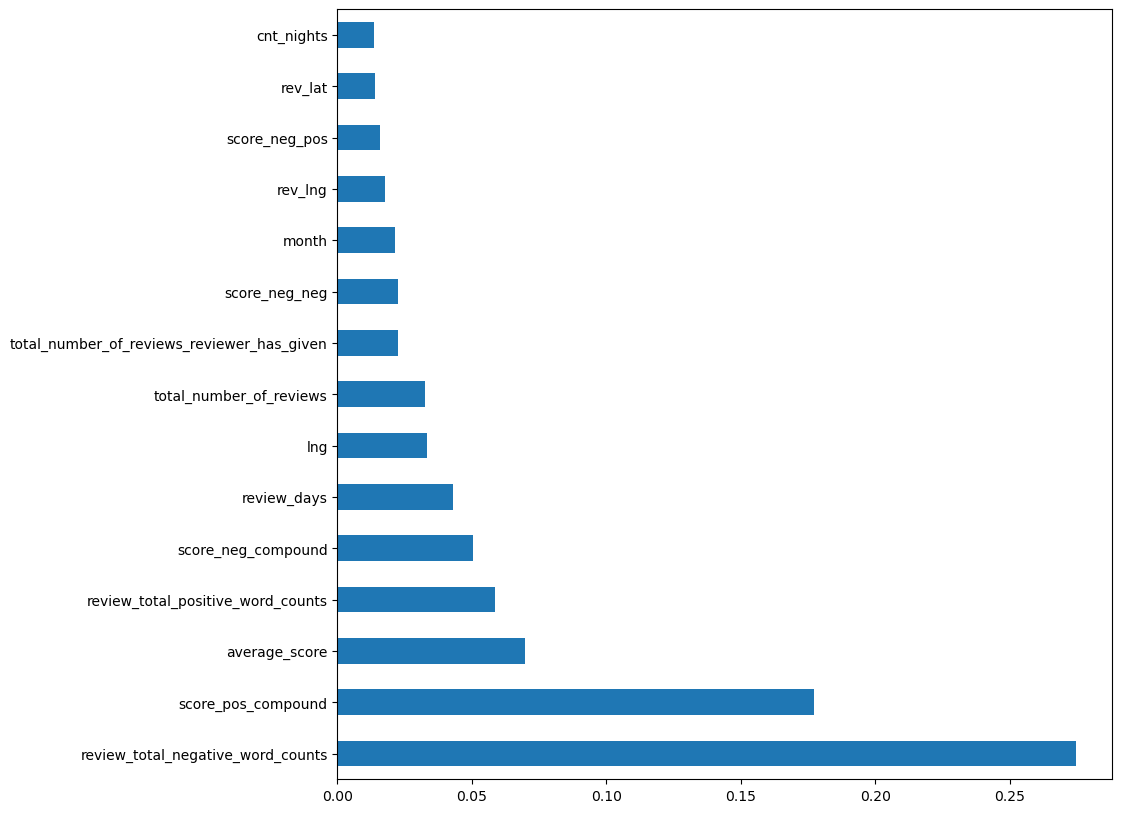

In [ ]:
# В RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
# Используем датасет с нормализацией методом RobustScaler.
# Повторим процедуру отбора признаков.
# Проведем поиск признаков с сильной корреляцией.
corr_r = df_r.drop(['sample', 'reviewer_score'], axis=1).corr()
        
# Создадим датафрейм-маску: для значений с коэффициентом корреляции больше или меньше 0,7 - значение True.
score_r = corr_r.apply(lambda x: ((x > 0.7) | (x < -0.7)), axis=1)
        
# Пройдем в цикле по строкам и столбцам полученного датафрейма и поместим признаки с сильной корреляцией в список.
ls_cor_r = list() 
for i in score_r.index:
    for j in score_r.columns:
        if (score_r.loc[i][j]) and (i != j):
            ls_cor_r.append([i, j, str(round(corr_r.loc[i][j], 2))])

# Разделим данные по признаку метке.
train_data_r = df_r.query('sample == 1').drop(['sample'], axis=1)
test_data_r = df_r.query('sample == 0').drop(['sample'], axis=1)
        
y_r = train_data_r['reviewer_score'] # наш таргет    
X_r = train_data_r.drop(['reviewer_score'], axis=1)
       
# Оценим важность признаков.
y_chi2_r = y_r.astype('int')        
X_abs_r = X_r.apply(lambda x: abs(x))
imp_cat_r = pd.Series(chi2(X_abs_r[cat_cols], y_chi2_r)[0], index=cat_cols)
imp_num_r = pd.Series(f_classif(X_r[num_cols], y_chi2_r)[0], index=num_cols)
        
# Объединим результаты оценки важности признаков в одну Series.
ls_feature_r = pd.concat([imp_num_r, imp_cat_r], sort=True)
                
# Создадим список признаков подлежащих исключению, выбрав из двух признаков с
# сильной корреляцией тот что менeе важен по результатам статистических тестов.
drop_ls_r = []
for i in ls_cor_r:
    if ls_feature_r[i[0]] <= ls_feature_r[i[1]]:
        drop_ls_r.append(i[0])
    else:
        drop_ls_r.append(i[1])

# Уберем повторы, преобразовав в множество и вернемся к списку для возможности 
# перебора значений по индексам.
drop_ls_r = (list(set(drop_ls_r)))

# Создадим копию датасета и уберем признаки признаки с высокой корреляцией.
dfr = df_r.copy()
dfr.drop(drop_ls_r, inplace=True, axis=1)

# Разделим данные по признаку метке.
train_data_dfr = dfr.query('sample == 1').drop(['sample'], axis=1)
test_data_dfr = dfr.query('sample == 0').drop(['sample'], axis=1)

y_dfr = train_data_dfr['reviewer_score'] # наш таргет    
X_dfr = train_data_dfr.drop(['reviewer_score'], axis=1)

# Делим тренирововчную выборку на данные для обучения и проверки модели.
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_dfr, y_dfr, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ).
model_r = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)          

# Обучаем модель на тестовом наборе данных.
model_r.fit(X_train_r, y_train_r)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred.
y_pred_r = model_r.predict(X_test_r)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
mape_r = np.mean(np.abs((y_test_r - y_pred_r)/y_test_r))*100 

# Выводим значение метрики.
print(mape_r)

12.328508863649343


<AxesSubplot:>

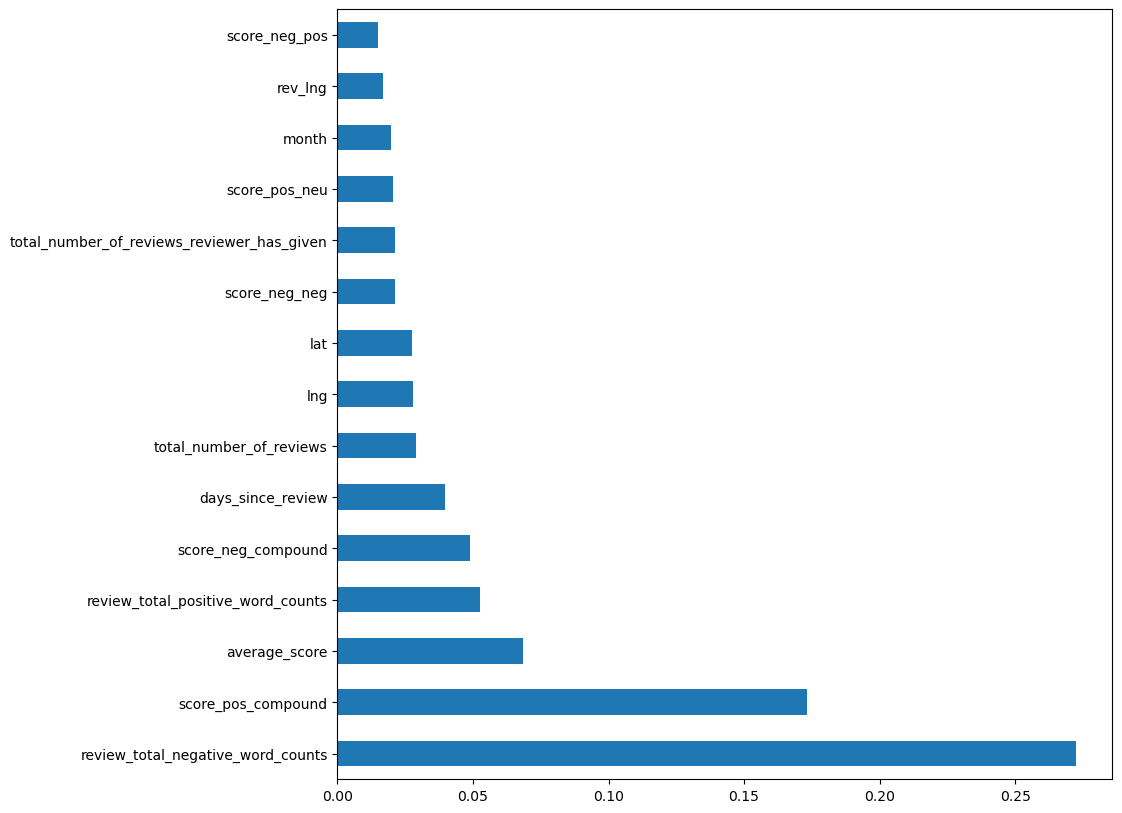

In [ ]:
# В RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances_r = pd.Series(model_r.feature_importances_, index=X_dfr.columns)
feat_importances_r.nlargest(15).plot(kind='barh')

In [ ]:
# Так как обе модели показывают близкие результаты принято решение проверить обе модели на тестовой выборке.
# Исключим из тестовых данных добавленный нами ранее целевой признак.
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
# Тоже самое делаем для данных с нормализацией методом RobustScaler.
test_data_dfr = test_data_dfr.drop(['reviewer_score'], axis=1)

In [ ]:
# Используем обученные модели для предсказания рейтинга отелей в тестовой выборке.
predict_submission = model.predict(test_data)
predict_submission_r = model_r.predict(test_data_dfr)

In [ ]:
# Записываем результаты в файлs сабмишена.
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('../data/submission_n.csv', index=False)
display(sample_submission.head(10))

sample_submission['reviewer_score'] = predict_submission_r
sample_submission.to_csv('../data/submission_r.csv', index=False)
display(sample_submission.head(10))

,reviewer_score,id
0,8.363,488440
1,7.320,274649
2,8.534,374688
3,9.687,404352
4,9.633,451596
5,8.787,302161
6,7.703,317079
7,7.724,13963
8,8.614,159785
9,7.226,195089


,reviewer_score,id
0,8.553,488440
1,6.951,274649
2,8.292,374688
3,9.832,404352
4,9.638,451596
5,8.931,302161
6,7.862,317079
7,7.504,13963
8,8.567,159785
9,7.108,195089


### Выводы по блоку обучение модели

В результате проведенной работы удалось получить два варианта модели: 
   * первый вариант модели использует данные без преобразования и показывает значение метрики МАРЕ = 12.330.
   * второй вариант модели использует данные с нормализацией методом RobustScaler и показывает значение метрики МАРЕ = 12.328.                
   
Анализ важности признаков каждой из моделей показывает, что первая пятерка признаков у них одинаковая, однако последующие признаки различаются. Видно что для обеих моделей наиболее важным являются признаки длины отзыва. Решение о их исправлении было правильным. Также можно отметить что обе модели используют временные признаки и признаки координат отеля и страны происхождения клиента.  
Результат на Kaggle для первого варианта - 12.42939, для второго варианта -12.42949. Модели показали очень близкие результаты на тестовых данных модель, однако модель обученная на данных без преобразований выдает лучший результат.




# Выводы по проекту 
В ходе проекта проведена работа по очистка данных, были восстановлены пропущенные значения координат отелей с использованием библиотеки geopy. Проведено исследование данных позволившее определить необходимость исправления некоторых признаков, например длины отзывов, разделения признака содержащего тэги, а также дало несколько идей по генерации новых признаков. В результате генерации новых признаков удалось получить набор данных из 98 числовых признаков. Проведено преобразование признаков: нормализация (MinMaxScaler и RobustScaler) и стандартизация (StandardScaler) как одиночное так и комбинированное. Для отбора признаков проведена проверка корреляции признаков и тесты на важность категориальных и номинальных признаков (тест хи-квадрат и f-classif). Проведен отбор признаков с высокой корреляцией по результатм теста на их важность. Признаки с меньшей важностью удалены. Проведена проверка моделей обученных на наборах данных с различными методами преобразования по метрике MAPE. Лучший результат показали модели обученные на данных без преобразования МАРЕ = 12.330 и модель обученная на данных с нормализацией методом RobustScaler МАРЕ = 12.328. 
Однако проверка на тестовых данных показала что лучший результат на Kaggle дает модель обученная на данных без преобразования МАРЕ = 12.42939.